## Task 5

"Power of two choices". Instead of throwing balls independently into bins, for each
ball we choose randomly d bins and check the number of balls inside. Then we place
the new ball in the bin (one of bins) with the smallest balls in the given moment. Check
experimentally, how parameter d influences random variables C, B and the maximal
load. Consider different d staring from 1. Note that the case d = 1 is just the regular
BiBa model

In [1]:
import numpy as np
from time import time
import numba
import timeit
from matplotlib import pyplot as plt

In [2]:
# index of an array is the number of bin, and value in that index is ball count
@numba.njit()
def choose_min_from_d_bins(array_with_bins, d):
    d_bins = np.random.choice(len(array_with_bins), size=d, replace=False)
    d_bins_count = array_with_bins[d_bins]
    array_with_bins[d_bins[d_bins_count.argmin()]] += 1
    return array_with_bins

In [3]:
@numba.njit()
def simulate_biba_until_all_not_empty(num_of_bins, d):
    bins = np.zeros(num_of_bins)
    counter = 0
    while 0 in bins:
        bins = choose_min_from_d_bins(bins, d)
        counter += 1
    return counter

In [4]:
@numba.njit(parallel=True)
def repeat_all_not_empty(num_of_bins, num_of_trials, d):
    results = np.zeros(num_of_trials)
    for i in numba.prange(num_of_trials):
        results[i] = simulate_biba_until_all_not_empty(num_of_bins, d)
    return results

In [5]:
def get_optimal_number_of_bins_for_histogram(histogram):
    stddev = np.std(histogram)
    n = len(histogram)
    width = (3.5 * stddev) / (n ** (1/3))
    range_of_data = histogram.max() - histogram.min()
    return int(np.ceil(range_of_data / width))

<ul><li>We throw independently balls into n bins until all bins are non-empty. Let C be the
number of thrown balls.</li></ul>

In [6]:
d = 30
number_of_bins = 100
number_of_trials = 10000

In [7]:
%%timeit 
simulate_biba_until_all_not_empty(number_of_bins, d)

155 µs ± 6.54 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
repeat_all_not_empty(number_of_bins, number_of_trials, d)

225 ms ± 8.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
number_of_bins = 500
number_of_trials = 10000
d_parameters = [1, 5, 10, 20, 50]
histograms = []
times = []

In [19]:
for d in d_parameters:
    time1 = time()
    histograms.append(repeat_all_not_empty(number_of_bins, number_of_trials, d))
    time2 = time()
    times.append(round(time2 - time1, 5))
print(*times)

29.8485 9.1155 6.1685 5.038 4.481


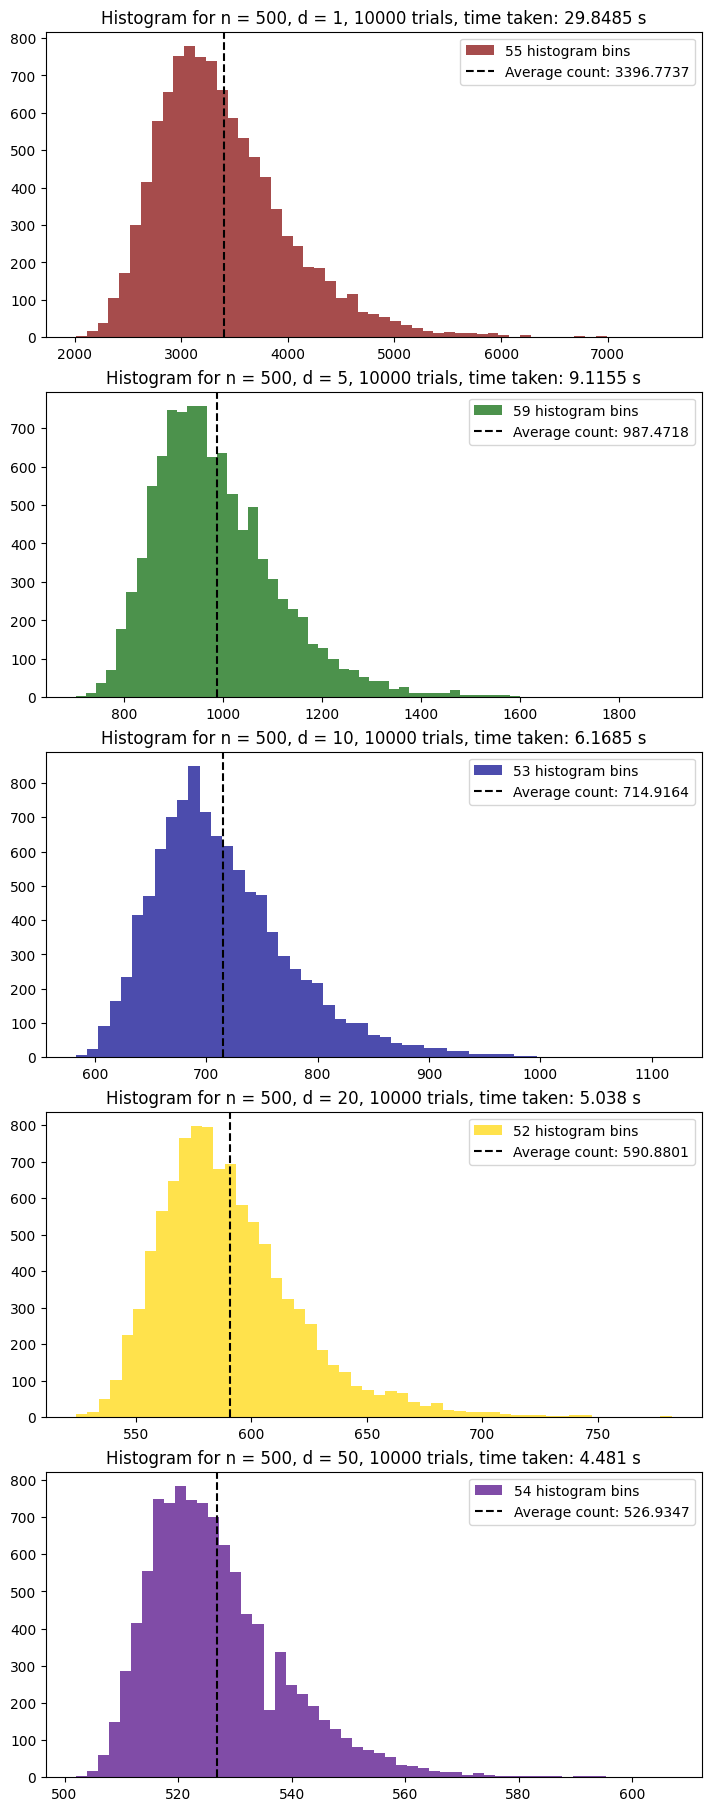

In [27]:
figure1, axes1 = plt.subplots(len(d_parameters), 1, layout='constrained', figsize=(7, 18))

colors = ['maroon', 'darkgreen', 'darkblue', 'gold', 'indigo']
for index, (d, histogram, time_, color) in enumerate(zip(d_parameters, histograms, times, colors)):
    mean_value = histogram.mean()
    histogram_bins = get_optimal_number_of_bins_for_histogram(histogram)
    axes1[index].hist(histogram, 
                      color=color, 
                      alpha=0.7, 
                      bins=histogram_bins, 
                      label=f'{histogram_bins} histogram bins')
    axes1[index].axvline(mean_value, 
                         color='black', 
                         linestyle='--', 
                         label=f'Average count: {mean_value}')
    title = f'Histogram for n = {number_of_bins}, d = {d}, {number_of_trials} trials, time taken: {time_} s'
    axes1[index].set(title=title)
    axes1[index].legend()

Let's stack histograms on one graph to compare them

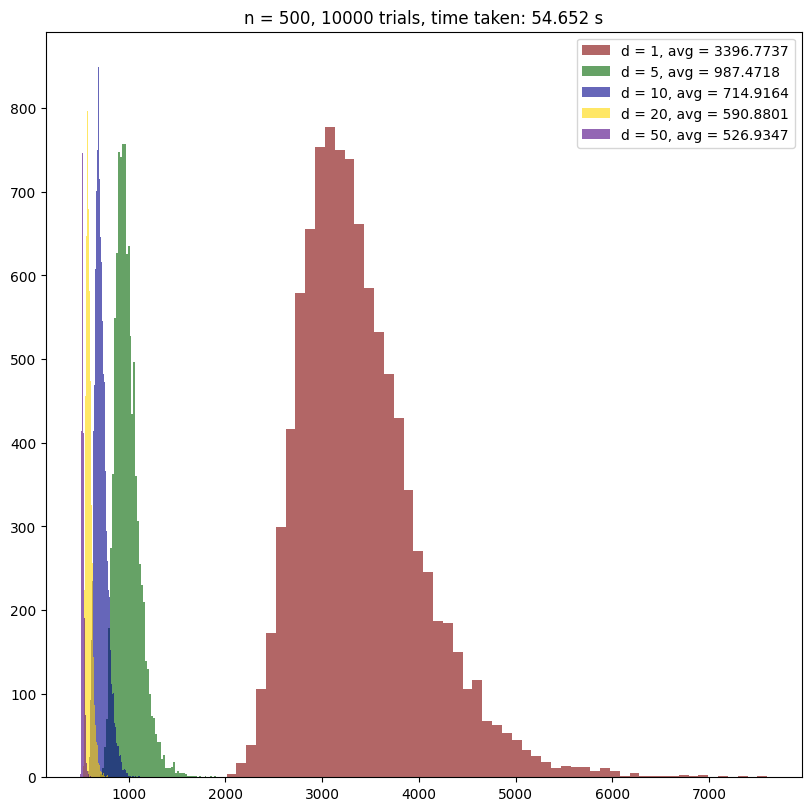

In [29]:
figure2, axes2 = plt.subplots(1, 1, layout='constrained', figsize=(8, 8))

for index, (d, histogram, color) in enumerate(zip(d_parameters, histograms, colors)):
    mean_value = histogram.mean()
    histogram_bins = get_optimal_number_of_bins_for_histogram(histogram)
    axes2.hist(histogram, 
               color=color, 
               alpha=0.6, 
               bins=histogram_bins, 
               label=f'd = {d}, avg = {mean_value}')
    title = f'n = {number_of_bins}, {number_of_trials} trials, time taken: {round(np.array(times).sum(), 3)} s'
    axes2.set(title=title)
    axes2.legend()

And let's see graph of average count in the function of d

In [42]:
def repeat_all_not_empty_for_range(num_of_bins, num_of_trials, d_range):
    results = np.zeros(len(d_range))
    times = np.zeros(len(d_range))
    for i, d in enumerate(d_range):
        time1 = time()
        results[i] = repeat_all_not_empty(number_of_bins, number_of_trials, d).mean()
        time2 = time()
        times[i] = round(time2 - time1, 5)
    return results, times

In [60]:
number_of_trials = 100
# d_array = np.concatenate((np.arange(1, 21, 1), np.arange(40, 501, 20)), axis=0)
d_array = np.arange(1, 40, 1)
n_list = [500, 200, 150, 100, 80]
d_list = []
time_list = []

In [59]:
%%timeit
repeat_all_not_empty_for_range(number_of_bins, number_of_trials, d_array)

2.87 s ± 46.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
d_function, d_time = repeat_all_not_empty_for_range(number_of_bins, number_of_trials, d_array)

[None]

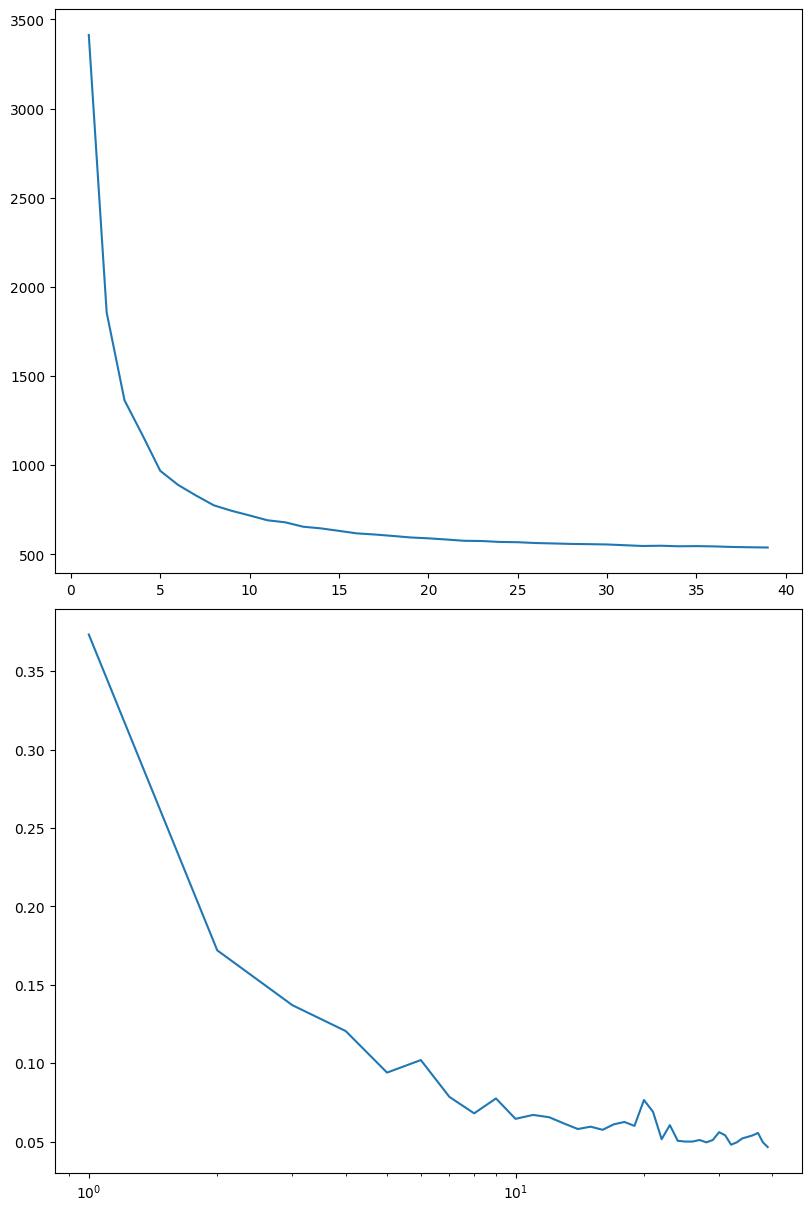

In [61]:
figure3, axes3 = plt.subplots(2, 1, layout='constrained', figsize=(8, 12))

axes3[0].plot(d_array, d_function)
# axes3[0].set(xscale='log')
axes3[1].plot(d_array, d_time)
axes3[1].set(xscale='log')